# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.utils.multiclass import unique_labels

from yellowbrick.model_selection import ValidationCurve
import shap

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')
set_config(display='diagram')


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
shap.initjs()

In [3]:
full_df = pd.read_csv('data/winequalityN.csv')

full_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Classification Objective

The most obvious classification objective for this training set is **multiclass wine quality classification**. 

The dataset is **higly imbalanced**. We have only 5 samples of exellent wines and 30 samples of the lowest quality wines. If we take into account test set split and cross-validation folds, we may have only a couple of examples during training. This means that there may be a problem of applying SMOTE and similar synthetical methods to balance datasets as they would require more samples to create clusters for samplings from.

Other possible objectives are:
- multiclass quality classification with only 3 classes: low, medium, high quality wines
- binary quality classification: good or bad quality wine
- binary wine type classification: red or white wine (which would also suffer from imbalance, but could be fixed by synthetic resampling)

In [4]:
full_df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

We will stick with **multiclass quality classification** and 3 classes: low, medium, high quality wines:

In [5]:
def impute_quality_group(quality):
    if quality <= 5:
        return 0 # low
    if quality > 5 and quality < 7:
        return 1 # average
    if quality >= 7:
        return 2 # high

full_df['quality_group'] = full_df['quality'].apply(impute_quality_group)

In [6]:
full_df['quality_group'].value_counts()

1    2836
0    2384
2    1277
Name: quality_group, dtype: int64

# Model

In [7]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)


In [8]:
def score_classification_model(model, X_train, y_train):
    
    cv_scores = cross_validate(
        model, X_train, y_train, 
        scoring=['f1_weighted', 'balanced_accuracy'],
        cv=5,
        n_jobs=-1, verbose=0
    )

    cv_y_predicted = cross_val_predict(
        model, X_train, y_train,
        cv=5,
        n_jobs=-1
    )

    cv_f1_weighted, f1_weighted_std = cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std()
    cv_balanced_accuracy, balanced_accuracy_std = cv_scores['test_balanced_accuracy'].mean(), cv_scores['test_balanced_accuracy'].std()

    model.fit(X_train, y_train)

    y_train_predicted = model.predict(X_train)

    train_f1_weighted = f1_score(y_train, y_train_predicted, average='weighted')
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_predicted)

    print('[Train] F1 Weighted: %.4f' % (train_f1_weighted))
    print('[Train] Balanced Accuracy: %.4f' % (train_balanced_accuracy))
    print('Train Set Report:')
    print(classification_report(y_train, y_train_predicted, digits=3))

    print('[CV] F1 Weighted: %.4f (%.4f)' % (cv_f1_weighted, f1_weighted_std))
    print('[CV] Balanced Accuracy: %.4f (%.4f)' % (cv_balanced_accuracy, balanced_accuracy_std))
    print('CV Report:')
    print(classification_report(y_train, cv_y_predicted, digits=3))
    
    # display confusion matrixes

    _, (ax0, ax1) = plt.subplots(1, 2)

    ax0.set_title('Train Confusion Matrix')
    plot_confusion_matrix(
        model, X_train, y_train,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax0,
    )

    ax1.set_title('CV Confusion Matrix')
    plot_confusion_matrix_by_predictions(
        y_train, cv_y_predicted,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax1,
    )

    return y_train_predicted, cv_y_predicted

In [9]:
# sklearn's pipeline API is limited at this point and doesn't provide a way to get columns of transformed X array
# This snippet will cover our back 

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    [_, _, reminder_columns] = column_transformer.transformers_[-1]

    for col_idx in reminder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

# Feature Engineering

In [10]:
for feature in ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
    full_df[feature] = full_df.groupby(['type'])[feature].transform(lambda x: x.fillna(x.median()))

In [11]:
def impute_sweetness(residual_sugar):
    if residual_sugar < 1:
        return 0
    if residual_sugar >= 1 and residual_sugar < 9:
        return 1
    if residual_sugar >= 9 and residual_sugar < 18:
        return 2
    if residual_sugar >= 18 and residual_sugar < 50:
        return 3
    if residual_sugar >= 50 and residual_sugar < 120:
        return 4
    if residual_sugar >= 120:
        return 5

full_df['sweetness'] = full_df['residual sugar'].apply(impute_sweetness)

In [12]:
full_df['fixed_acidity_red_wine'] = (full_df['type'] == 'red') * full_df['fixed acidity']
full_df['fixed_acidity_white_wine'] = (full_df['type'] == 'white') * full_df['fixed acidity']

full_df['molecular_sulfur_dioxid'] = full_df['free sulfur dioxide'] / (1 + 10 ** (full_df['pH'] - 1.8))
full_df['free_total_so2_rate'] = full_df['free sulfur dioxide'] / full_df['total sulfur dioxide']
full_df['bound_sulfur_dioxid'] = full_df['total sulfur dioxide'] - full_df['free sulfur dioxide']
full_df['sugar_acidity_ratio'] = full_df['residual sugar'] / full_df['fixed acidity']

alcohol_labels = ['low', 'medium', 'high']
alcohol_bins = [0, 9.5, 11.5, 20]
full_df['alcohol_groups'] = pd.cut(full_df['alcohol'], bins=alcohol_bins, labels=alcohol_labels) 

pH_labels = ['high', 'mod high', 'medium', 'low']
pH_bins = [2.5, 3.2, 3.3, 3.4, 4.1]
full_df['pH_groups'] = pd.cut(full_df['pH'], bins=pH_bins, labels=pH_labels) 

Feature Engineering:
- `total sulfur dioxide` - doesn't improve models in a raw view
- `free_total_so2_rate` - brings 0 improvements
- `sweetness` - degrades performance of all models
- `alcohol_groups` - degrades performance of all models
- `pH_groups` - degrades performance of all models
- `sugar_acidity_ratio` improves score's std but degrades CV scores

In [13]:
model_features = [
    'type',
    'alcohol',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'pH',
    'residual sugar',
    'free sulfur dioxide',
    'chlorides',
    'density',
    'sulphates',
    'bound_sulfur_dioxid',
    'molecular_sulfur_dioxid',
    'sugar_acidity_ratio'
]

X = full_df[model_features]
y = full_df['quality_group']

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in stratified_splitter.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

# Data Processing

In [14]:
def get_feature_transformer():
    oneplus_transformer = FunctionTransformer(func=lambda x: 1 + x, inverse_func=lambda x: 1 - x)
    boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)

    numerical_transformer = Pipeline([
        ('positive_transforming', oneplus_transformer),
        ('boxcox_transforming', boxcox_transformer),
    ])

    return ColumnTransformer([
            ('feature_transforming', numerical_transformer, [
                'fixed acidity', 'chlorides', 'citric acid', 'volatile acidity', 
                'sulphates', 'alcohol', 'residual sugar', 'free sulfur dioxide', 
                'sulphates', 'pH', 'sugar_acidity_ratio'
            ]),
            ('wine_type_onehot', OneHotEncoder(), ['type']),
        ],
        remainder='passthrough'
    )

# LogisticRegression

In [15]:
logistic_regression = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    C=0.9,
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

logistic_regression_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_regression),
])

logistic_regression_pipeline

## [Tr] F1 Weighted: 0.5732, Balanced Accuracy: 0.5920
## [CV] F1 Weighted: 0.5688 (0.0135), Balanced Accuracy: 0.5866 (0.0099)
# solver='liblinear',
# penalty='l1',
# C=0.9,
# max_iter=500,
# class_weight='balanced'

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function get_feature_transformer.<locals>.<lambda> at 0x142613160>,
                                                                                       inverse_func=<function get_feature_transformer.<locals>.<lambda> at 0x1426131f0>)),
                                                                  ('boxcox_transforming...
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(C=0.9, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, penalty='l1',
                                    random_state=42, solver='liblinear'))])

[Train] F1 Weighted: 0.5732
[Train] Balanced Accuracy: 0.5920
Train Set Report:
              precision    recall  f1-score   support

           0      0.630     0.726     0.674      1907
           1      0.580     0.443     0.502      2269
           2      0.489     0.607     0.542      1021

    accuracy                          0.579      5197
   macro avg      0.566     0.592     0.573      5197
weighted avg      0.580     0.579     0.573      5197

[CV] F1 Weighted: 0.5688 (0.0135)
[CV] Balanced Accuracy: 0.5866 (0.0099)
CV Report:
              precision    recall  f1-score   support

           0      0.629     0.718     0.670      1907
           1      0.574     0.442     0.500      2269
           2      0.482     0.599     0.534      1021

    accuracy                          0.574      5197
   macro avg      0.561     0.587     0.568      5197
weighted avg      0.576     0.574     0.569      5197



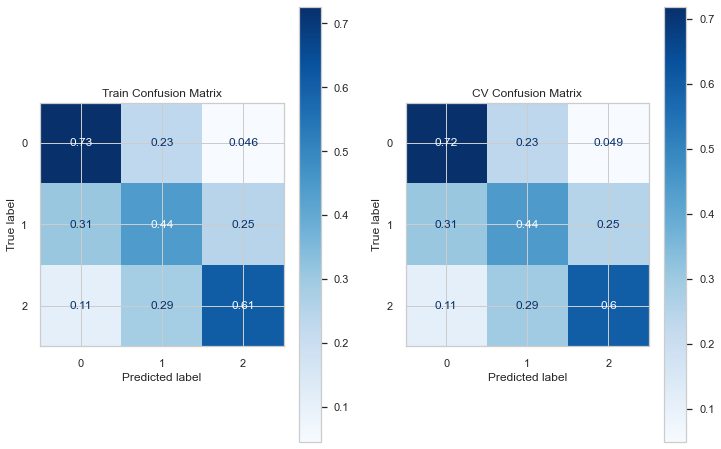

In [16]:
score_classification_model(logistic_regression_pipeline, X_train, y_train);

## Hyperparam Tuning

In [17]:
parameters = {
    'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
    'quality_classification__C': [1.0, 0.95, 0.9, 0.8], # 1.0
    'quality_classification__tol': [1e-4],
    'quality_classification__class_weight': ['balanced'],
    'quality_classification__solver': ['lbfgs', 'liblinear', 'sag', 'saga'], # lbfgs
    'quality_classification__max_iter': [500],
    'quality_classification__l1_ratio': [1.0, 0.0, 0.3, 0.4, 0.5],
}

param_searcher = GridSearchCV(
   estimator=logistic_regression_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Polynomial Regression

In [18]:
logistic_classifier = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

polynomial_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('polynomial_features', PolynomialFeatures()),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_classifier),
])

polynomial_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function get_feature_transformer.<locals>.<lambda> at 0x1427e0ee0>,
                                                                                       inverse_func=<function get_feature_transformer.<locals>.<lambda> at 0x1427e0ca0>)),
                                                                  ('boxcox_transforming...
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('polynomial_features', PolynomialFeatures()),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='newton-cg'))])

[Train] F1 Weighted: 0.5900
[Train] Balanced Accuracy: 0.6313
Train Set Report:
              precision    recall  f1-score   support

           0      0.675     0.735     0.704      1907
           1      0.614     0.419     0.498      2269
           2      0.480     0.740     0.583      1021

    accuracy                          0.598      5197
   macro avg      0.590     0.631     0.595      5197
weighted avg      0.610     0.598     0.590      5197

[CV] F1 Weighted: 0.5723 (0.0111)
[CV] Balanced Accuracy: 0.6156 (0.0150)
CV Report:
              precision    recall  f1-score   support

           0      0.655     0.725     0.688      1907
           1      0.595     0.396     0.475      2269
           2      0.470     0.726     0.571      1021

    accuracy                          0.581      5197
   macro avg      0.573     0.616     0.578      5197
weighted avg      0.592     0.581     0.572      5197



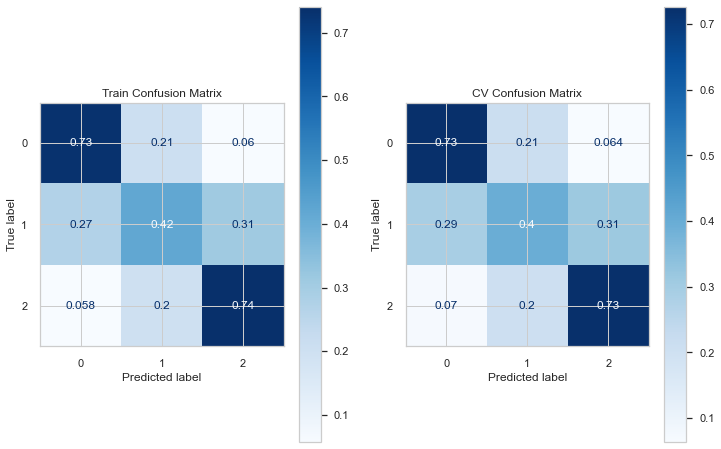

In [19]:
score_classification_model(polynomial_pipeline, X_train, y_train);

### Hyperparam Tuning

In [20]:
parameters = [
    {
        'quality_classification__solver': ['newton-cg'], # lbfgs, liblinear, 'lbfgs', 'sag', 'saga',
        'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
        'quality_classification__C': [1.0], # 1.0
        'quality_classification__l1_ratio': [1.0, 0.9],
        'quality_classification__max_iter': [100, 200],
        'quality_classification__class_weight': ['balanced'],
        'polynomial_features__degree': [2],
    },
]

param_searcher = GridSearchCV(
   estimator=polynomial_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# SVC

In [21]:
from sklearn.svm import LinearSVC, SVC

lsvm_classifier = LinearSVC(
    C=0.01,
    max_iter=1000,
    loss='squared_hinge',
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

lsvm_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('scaling', StandardScaler()),
    ('quality_classification', lsvm_classifier),
])

psvm_classifier = SVC(
    kernel='poly',
    degree=4,
    coef0=1,
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

psvm_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('scaling', StandardScaler()),
    ('quality_classification', psvm_classifier),
])

ksvm_classifier = SVC(
    kernel='rbf',
    C=5,
    gamma=0.01,
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

ksvm_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('scaling', StandardScaler()),
    ('quality_classification', ksvm_classifier),
])

[Train] F1 Weighted: 0.5590
[Train] Balanced Accuracy: 0.5868
Train Set Report:
              precision    recall  f1-score   support

           0      0.621     0.747     0.678      1907
           1      0.579     0.397     0.471      2269
           2      0.468     0.616     0.532      1021

    accuracy                          0.569      5197
   macro avg      0.556     0.587     0.560      5197
weighted avg      0.572     0.569     0.559      5197

[CV] F1 Weighted: 0.5552 (0.0132)
[CV] Balanced Accuracy: 0.5846 (0.0094)
CV Report:
              precision    recall  f1-score   support

           0      0.618     0.746     0.676      1907
           1      0.576     0.390     0.465      2269
           2      0.465     0.617     0.530      1021

    accuracy                          0.566      5197
   macro avg      0.553     0.585     0.557      5197
weighted avg      0.569     0.566     0.555      5197



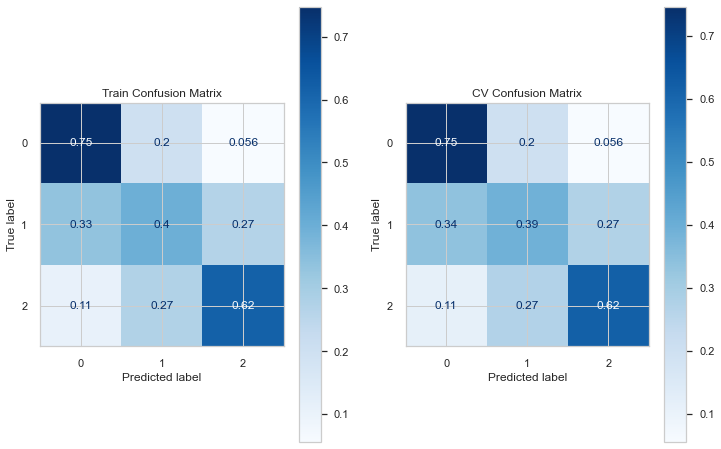

In [22]:
score_classification_model(lsvm_pipeline, X_train, y_train);

# [CV] F1 Weighted: 0.5552 (0.0132)
# [CV] Balanced Accuracy: 0.5846 (0.0094)

[Train] F1 Weighted: 0.6874
[Train] Balanced Accuracy: 0.7242
Train Set Report:
              precision    recall  f1-score   support

           0      0.727     0.811     0.767      1907
           1      0.746     0.533     0.622      2269
           2      0.584     0.829     0.685      1021

    accuracy                          0.693      5197
   macro avg      0.686     0.724     0.691      5197
weighted avg      0.707     0.693     0.687      5197

[CV] F1 Weighted: 0.6072 (0.0154)
[CV] Balanced Accuracy: 0.6388 (0.0167)
CV Report:
              precision    recall  f1-score   support

           0      0.671     0.736     0.702      1907
           1      0.626     0.463     0.532      2269
           2      0.513     0.718     0.598      1021

    accuracy                          0.613      5197
   macro avg      0.603     0.639     0.611      5197
weighted avg      0.620     0.613     0.607      5197



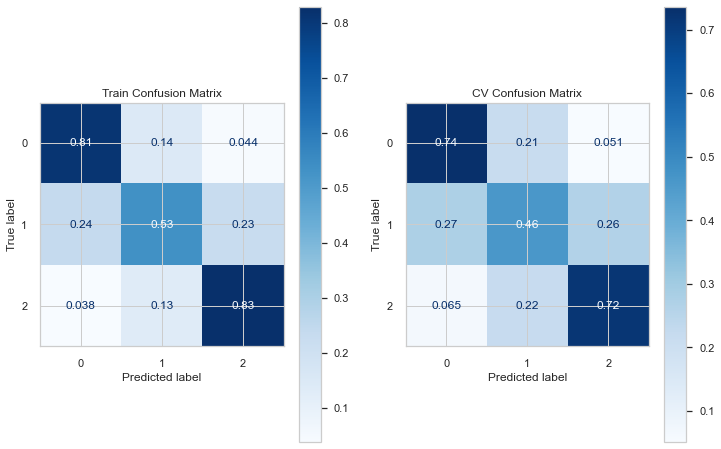

In [23]:
score_classification_model(psvm_pipeline, X_train, y_train);

## [Train] F1 Weighted: 0.5476, Balanced Accuracy: 0.5654
## [CV] F1 Weighted: 0.5225 (0.0097), Balanced Accuracy: 0.5395 (0.0134)
# kernel='poly',
# degree=2,
# class_weight='balanced'

## [Train] F1 Weighted: 0.5979, Balanced Accuracy: 0.6337
## [CV] F1 Weighted: 0.5807 (0.0036), Balanced Accuracy: 0.6147 (0.0090)
# kernel='poly',
# degree=2,
# coef0=1,
# class_weight='balanced'

## [Train] F1 Weighted: 0.6323, Balanced Accuracy: 0.6724
## [CV] F1 Weighted: 0.5865 (0.0068), Balanced Accuracy: 0.6264 (0.0127)
# kernel='poly',
# degree=3,
# coef0=1,
# class_weight='balanced'

## [Train] F1 Weighted: 0.6874, Balanced Accuracy: 0.7242
## [CV] F1 Weighted: 0.6072 (0.0154), Balanced Accuracy: 0.6388 (0.0167)
# kernel='poly',
# degree=4,
# coef0=1,
# class_weight='balanced'

[Train] F1 Weighted: 0.5954
[Train] Balanced Accuracy: 0.6341
Train Set Report:
              precision    recall  f1-score   support

           0      0.663     0.759     0.708      1907
           1      0.624     0.423     0.504      2269
           2      0.498     0.721     0.589      1021

    accuracy                          0.605      5197
   macro avg      0.595     0.634     0.600      5197
weighted avg      0.613     0.605     0.595      5197

[CV] F1 Weighted: 0.5784 (0.0041)
[CV] Balanced Accuracy: 0.6191 (0.0039)
CV Report:
              precision    recall  f1-score   support

           0      0.646     0.737     0.689      1907
           1      0.599     0.406     0.484      2269
           2      0.491     0.714     0.582      1021

    accuracy                          0.588      5197
   macro avg      0.579     0.619     0.585      5197
weighted avg      0.595     0.588     0.578      5197



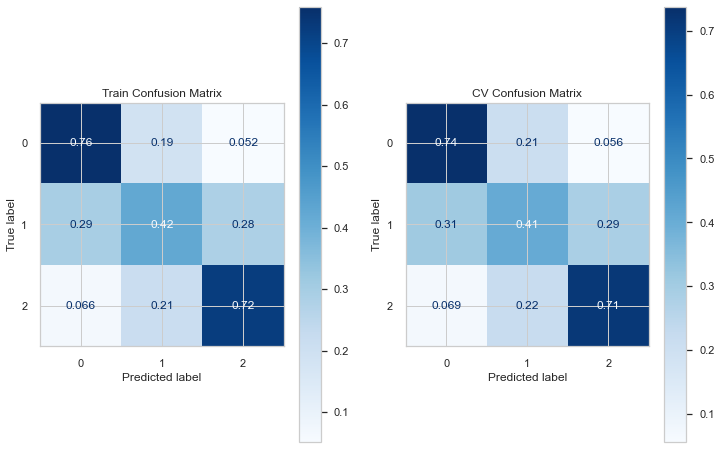

In [24]:
score_classification_model(ksvm_pipeline, X_train, y_train);

## [Train] F1 Weighted: 0.7151, [CV] Balanced Accuracy: 0.7483
## [CV] F1 Weighted: 0.6048 (0.0102), [CV] Balanced Accuracy: 0.6400 (0.0124)
# kernel='rbf',
# C=10,
# class_weight='balanced'

## [Train] F1 Weighted: 0.6772, [CV] Balanced Accuracy: 0.7152
## [CV] F1 Weighted: 0.5971 (0.0140), [CV] Balanced Accuracy: 0.6353 (0.0190)
# kernel='rbf',
# C=5,
# class_weight='balanced'

## [Train] F1 Weighted: 0.5954, [CV] Balanced Accuracy: 0.6341
## [CV] F1 Weighted: 0.5784 (0.0041), [CV] Balanced Accuracy: 0.6191 (0.0039)
# kernel='rbf',
# C=5,
# gamma=0.01,
# class_weight='balanced'

### Hypertuning

In [25]:
parameters = {
    'quality_classification__C': [0.01, 0.1, 1],
}

param_searcher = GridSearchCV(
   estimator=lsvm_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

# param_searcher.fit(X_train, y_train)
# param_searcher.best_params_, param_searcher.best_score_

In [26]:
parameters = {
    'quality_classification__C': [20, 60, 70, 80, 90],
    'quality_classification__gamma': ['scale', 'auto', 0.01, 0.1, 1, 5, 10],
}

param_searcher = GridSearchCV(
   estimator=ksvm_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# DecisionTree

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(
    max_depth=12,
    max_leaf_nodes=65,
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

tree_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('quality_classification', tree_classifier),
])

## [CV] F1 Weighted: 0.5421 (0.0147), Balanced Accuracy: 0.5787 (0.0163)
# max_leaf_nodes=25

[Train] F1 Weighted: 0.6211
[Train] Balanced Accuracy: 0.6688
Train Set Report:
              precision    recall  f1-score   support

           0      0.671     0.770     0.717      1907
           1      0.677     0.440     0.533      2269
           2      0.530     0.796     0.636      1021

    accuracy                          0.631      5197
   macro avg      0.626     0.669     0.629      5197
weighted avg      0.646     0.631     0.621      5197

[CV] F1 Weighted: 0.5646 (0.0135)
[CV] Balanced Accuracy: 0.5992 (0.0127)
CV Report:
              precision    recall  f1-score   support

           0      0.642     0.703     0.671      1907
           1      0.584     0.412     0.483      2269
           2      0.462     0.683     0.551      1021

    accuracy                          0.572      5197
   macro avg      0.563     0.599     0.568      5197
weighted avg      0.581     0.572     0.565      5197



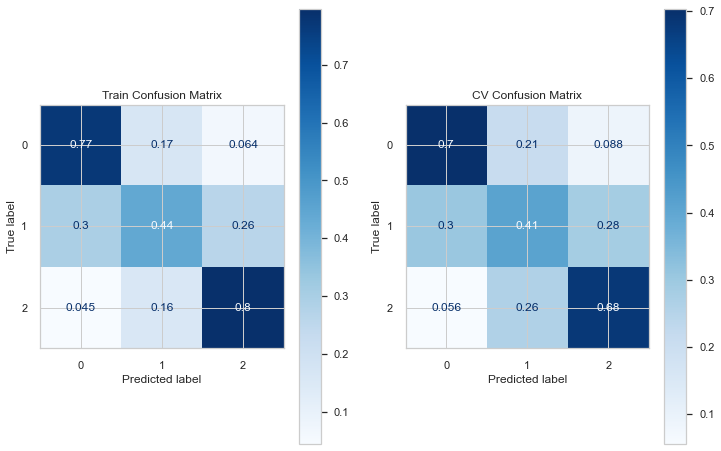

In [28]:
score_classification_model(tree_pipeline, X_train, y_train);

In [29]:
parameters = {
    'quality_classification__max_depth': np.arange(1, 15),
    'quality_classification__max_leaf_nodes': np.arange(1, 80, 5),
}

param_searcher = GridSearchCV(
   estimator=tree_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

param_searcher.fit(X_train, y_train)
param_searcher.best_params_, param_searcher.best_score_

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:    9.2s finished


({'quality_classification__max_depth': 12,
  'quality_classification__max_leaf_nodes': 66},
 0.599384459095854)

# RandomForest

In [30]:
rf_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=200,
    max_depth=6,
    max_leaf_nodes=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

rf_pipeline = Pipeline([
    ('feature_processing', get_feature_transformer()),
    ('quality_classification', rf_classifier),
])

rf_pipeline

## F1 Weighted: 0.6949 (0.0167), Balanced Accuracy: 0.6948 (0.0211)
# criterion='entropy',
# n_estimators=179,
# min_samples_split=5,
# min_samples_leaf=4,
# max_features='sqrt',
# class_weight='balanced'

## F1 Weighted: 0.4946 (0.0078), Balanced Accuracy: 0.5912 (0.0106)
# criterion='entropy',
# n_estimators=200,
# max_depth=6,
# max_leaf_nodes=10,
# max_features='sqrt',
# class_weight='balanced'

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function get_feature_transformer.<locals>.<lambda> at 0x142c5a940>,
                                                                                       inverse_func=<function get_feature_transformer.<locals>.<lambda> at 0x142c5a430>)),
                                                                  ('boxcox_transforming...
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=6,
                                        max_features='sqrt', max_leaf_nodes=10,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

[Train] F1 Weighted: 0.5056
[Train] Balanced Accuracy: 0.5991
Train Set Report:
              precision    recall  f1-score   support

           0      0.603     0.772     0.677      1907
           1      0.600     0.235     0.338      2269
           2      0.432     0.790     0.559      1021

    accuracy                          0.541      5197
   macro avg      0.545     0.599     0.524      5197
weighted avg      0.568     0.541     0.506      5197

[CV] F1 Weighted: 0.4946 (0.0078)
[CV] Balanced Accuracy: 0.5912 (0.0106)
CV Report:
              precision    recall  f1-score   support

           0      0.596     0.772     0.673      1907
           1      0.584     0.219     0.319      2269
           2      0.426     0.782     0.551      1021

    accuracy                          0.533      5197
   macro avg      0.535     0.591     0.514      5197
weighted avg      0.557     0.533     0.495      5197



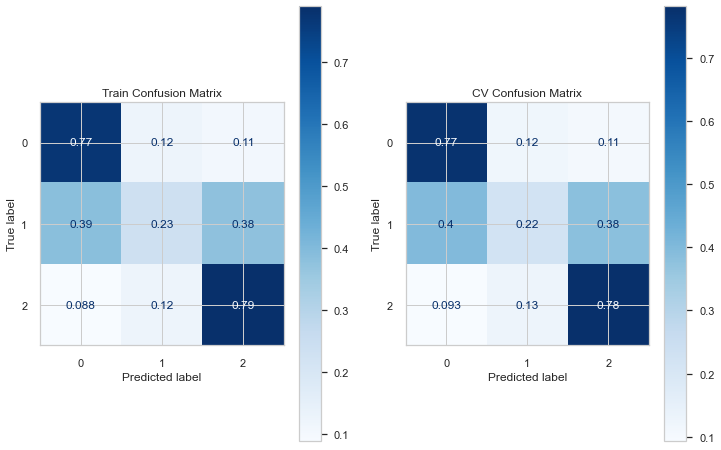

In [31]:
y_train_pred, y_cv_pred = score_classification_model(rf_pipeline, X_train, y_train);

# Model Inspection

In [32]:
X_train_features = get_columns_from_transformer(rf_pipeline.named_steps['feature_processing'], list(X_train.columns))

In [33]:
features_importance = sorted(zip(rf_pipeline.named_steps['quality_classification'].feature_importances_, X_train_features), reverse=True)

pd.DataFrame(features_importance, columns=['importance', 'feature'])

,importance,feature
0,0.422726,alcohol
1,0.161098,density
2,0.118943,volatile acidity
3,0.080546,chlorides
4,0.062556,citric acid
5,0.024771,bound_sulfur_dioxid
6,0.022967,sugar_acidity_ratio
7,0.020081,sulphates
8,0.020080,sulphates
9,0.019626,free sulfur dioxide


# Generalization

In [34]:
def score_model_generalization(model, X_test, y_test):
    y_test_predicted = model.predict(X_test)

    test_f1_weighted = f1_score(y_test, y_test_predicted, average='weighted')
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)

    print('[Test] F1 Weighted: %.4f' % (test_f1_weighted))
    print('[Test] Balanced Accuracy: %.4f' % (test_balanced_accuracy))
    print('Test Set Report:')
    print(classification_report(y_test, y_test_predicted, digits=3))

    plot_confusion_matrix_by_predictions(
        y_test, y_test_predicted,
        cmap=plt.cm.Greens,
        normalize='true',
    )

## Logistic Regression

[Test] F1 Weighted: 0.5458
[Test] Balanced Accuracy: 0.5620
Test Set Report:
              precision    recall  f1-score   support

           0      0.615     0.679     0.645       477
           1      0.535     0.429     0.476       567
           2      0.464     0.578     0.515       256

    accuracy                          0.550      1300
   macro avg      0.538     0.562     0.545      1300
weighted avg      0.550     0.550     0.546      1300



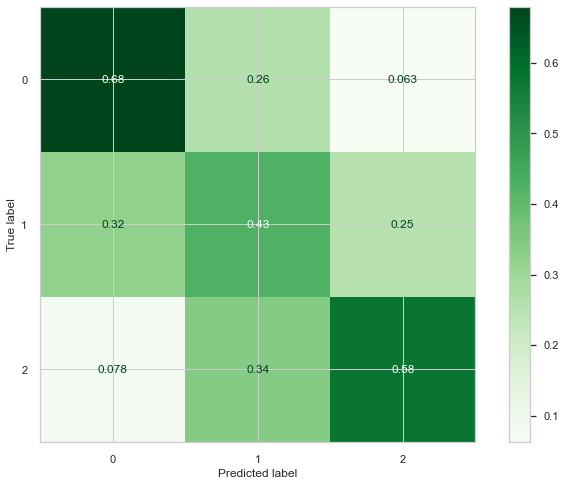

In [35]:
score_model_generalization(logistic_regression_pipeline, X_test, y_test)

## Polynomial Regression

[Test] F1 Weighted: 0.5558
[Test] Balanced Accuracy: 0.6050
Test Set Report:
              precision    recall  f1-score   support

           0      0.644     0.709     0.675       477
           1      0.563     0.372     0.448       567
           2      0.470     0.734     0.573       256

    accuracy                          0.567      1300
   macro avg      0.559     0.605     0.565      1300
weighted avg      0.574     0.567     0.556      1300



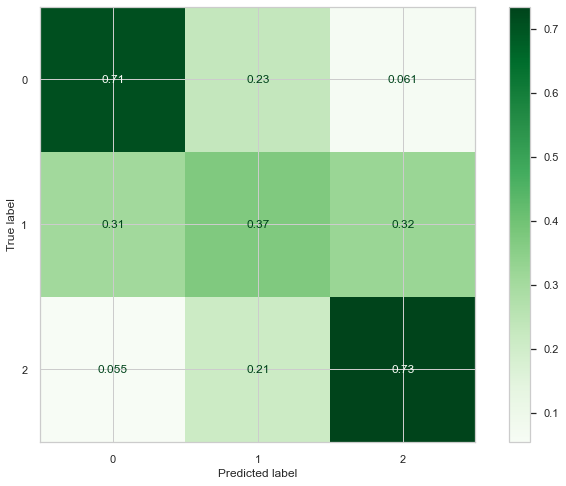

In [36]:
score_model_generalization(polynomial_pipeline, X_test, y_test)

## SVM

[Test] F1 Weighted: 0.5264
[Test] Balanced Accuracy: 0.5605
Test Set Report:
              precision    recall  f1-score   support

           0      0.599     0.704     0.647       477
           1      0.527     0.360     0.428       567
           2      0.449     0.617     0.520       256

    accuracy                          0.537      1300
   macro avg      0.525     0.560     0.532      1300
weighted avg      0.538     0.537     0.526      1300



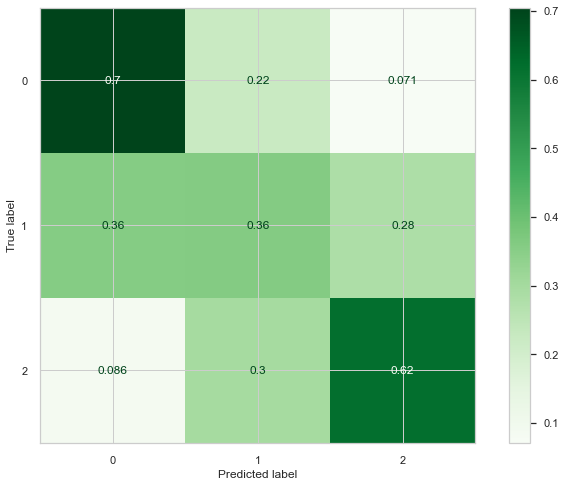

In [37]:
score_model_generalization(lsvm_pipeline, X_test, y_test)

[Test] F1 Weighted: 0.5845
[Test] Balanced Accuracy: 0.6173
Test Set Report:
              precision    recall  f1-score   support

           0      0.654     0.717     0.684       477
           1      0.597     0.436     0.504       567
           2      0.493     0.699     0.578       256

    accuracy                          0.591      1300
   macro avg      0.581     0.617     0.589      1300
weighted avg      0.597     0.591     0.584      1300



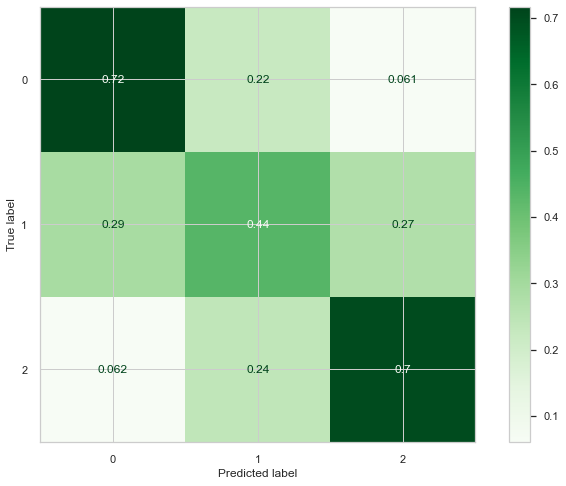

In [38]:
score_model_generalization(psvm_pipeline, X_test, y_test)

[Test] F1 Weighted: 0.5500
[Test] Balanced Accuracy: 0.5907
Test Set Report:
              precision    recall  f1-score   support

           0      0.636     0.713     0.672       477
           1      0.549     0.376     0.446       567
           2      0.464     0.684     0.553       256

    accuracy                          0.560      1300
   macro avg      0.550     0.591     0.557      1300
weighted avg      0.564     0.560     0.550      1300



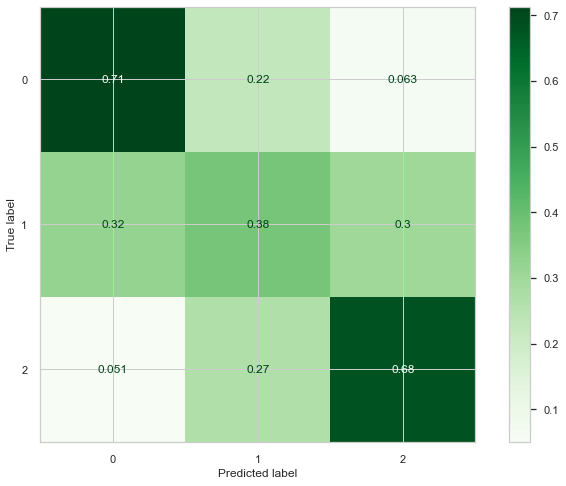

In [39]:
score_model_generalization(ksvm_pipeline, X_test, y_test)

## Random Forest

[Test] F1 Weighted: 0.4937
[Test] Balanced Accuracy: 0.5766
Test Set Report:
              precision    recall  f1-score   support

           0      0.600     0.740     0.663       477
           1      0.542     0.240     0.333       567
           2      0.416     0.750     0.536       256

    accuracy                          0.524      1300
   macro avg      0.520     0.577     0.510      1300
weighted avg      0.539     0.524     0.494      1300



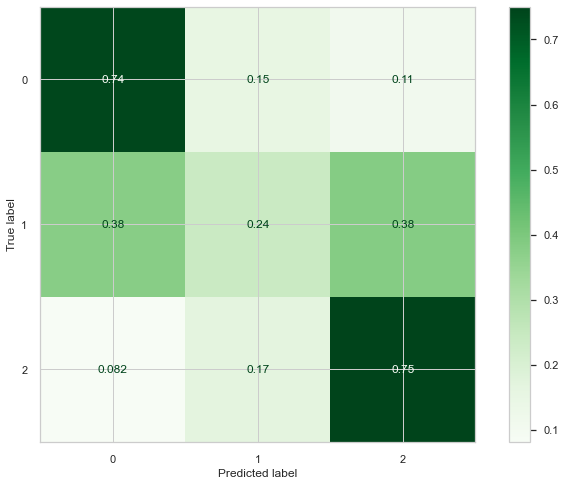

In [40]:
score_model_generalization(rf_pipeline, X_test, y_test)

# Summary 💫

Wine Quality database is a good example of datasets you may face in the real life. It's **imbalanced** and **quality classes** are hard to separate. It pushed us to rethinking the our classification objectives and assuming what we could potentialy sqeeze from it.

We have trained several models from a simple Logistic Regression and SVM to RandomForest and measured their performance with **balanced accuracy** metric.

Turned out, the polinomial **SVC model** performs best for us:
- CV: 63.88% (-+1.67%)
- Test: 61.73% 

Our goal was to get the higher balanced accuracy while keeping a score difference between train and CV scores small.

RandomForest and XGBoost are easily overfit and show around 70% of balanced accuracy on the CV and test datasets (while almost 100% on training sets). However, we don't believe these model would generalize when even if they showed good results on the current test set (which include only 1300 observations (20% of the overall dataset)).

**Another approach to improve the accuracy** is to train two separate models for red and white wines. Meanwhile, the fact that quality classes are hardly separable makes us think it would be little improvement